In [1]:
import numpy as np
import tensorflow as tf
import afqstensorutils as atu
from matplotlib import pylab as plt

In [2]:
@tf.RegisterGradient('TruncateMod')
def grad_truncate_mod(unused_op, grad):
    return grad, tf.constant(1)

A simple example is the pendulum,
\begin{align}
\text{Solve for}\, x(t), \, y(t), \, f(t) \, \text{satisfying:} \\
m \dot{x} & = f x/L \\
m \dot{y} & = f y/L + m g \\
x^2 + y^2 & = L^2
\end{align}
In our methodology, we do not have an explicit equation for the constraint, but a dataset of (x,y) pairs that are on the manifold. For our proof-of-concept test, we manufacture this data for the pendulum.

The Lagrangian for the pendulum is 
\begin{equation}
\mathcal{L} = \frac{1}{2}m\left(\dot{x}^2 + \dot{y}^2\right) - m g y
\end{equation}
with the constraint that $x$ and $y$ lie on the path. The equations of motion given some parameter space that satisfies the constraint is
\begin{equation}
\frac{\mathrm{d}q}{\mathrm{d}t}\frac{\partial L}{\partial \dot{q}} = \frac{\partial L}{\partial q}.
\end{equation}

We'll use the autoencoder to generate the parameterization of $x(q)$ and $y(q)$. By the chain rule, the velocities are related to the feature space by 
\begin{equation}
\dot{x} = \frac{\mathrm{d}x(q)}{\mathrm{d}t} = \frac{\partial x}{\partial q}\frac{\mathrm{d}q}{\mathrm{d}t}
\end{equation}
and similarly for the $y$ direction.

Taking the partial derivatives with respect to the feature variable and its rate, the components to the equation of motion are 
\begin{equation}
\frac{\partial L}{\partial q} = m g \frac{\partial y}{\partial q}
\end{equation}
and
\begin{equation}
\frac{\partial L}{\partial \dot{q}} = m \left( \frac{\partial x}{\partial q}\frac{\partial x}{\partial q} + \frac{\partial y}{\partial q}\frac{\partial y}{\partial q} \right) \dot{q}
\end{equation}
which give us the equation
\begin{equation}
m \left( \frac{\partial x}{\partial q}\frac{\partial x}{\partial q} + \frac{\partial y}{\partial q}\frac{\partial y}{\partial q} \right) \ddot{q} =  m g \frac{\partial y}{\partial q}
\end{equation}

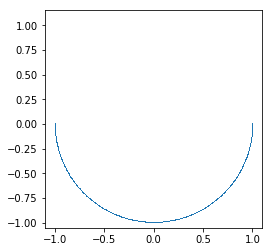

In [3]:
theta = np.linspace(-np.pi,0.0*np.pi,500, dtype=np.float32)
data = np.vstack([np.cos(theta), np.sin(theta)]).T
plt.plot(data[:,0],data[:,1],',')
plt.axis('square')
dataset = tf.data.Dataset.from_tensor_slices(data)

Yup, that's a circle. Can we find an autoencoder for this circle?

In [4]:
graph = tf.Graph()
tf.set_random_seed(1234) # Make this notebook deterministic for debugging
with graph.as_default():
    # Input variables of the network
    repeat_dataset = dataset.repeat()
    shuffled_dataset = repeat_dataset.shuffle(buffer_size=1000)
    batched_dataset = shuffled_dataset.batch(100)
    iterator = batched_dataset.make_one_shot_iterator()
    next_element = iterator.get_next()
    tr_x = tf.stack(next_element)
    
    #
    # The parameters
    N_poly_en = 2
    N_poly_de = 7
    N_poly_coeff_en = atu.Npolyexpand(2,N_poly_en)
    N_poly_coeff_de = atu.Npolyexpand(1,N_poly_de)
    p_V, (We1,be1, Wd1,bd1) = atu.CatVariable(
        [ (N_poly_coeff_en,1), (1,),
          (N_poly_coeff_de,2), (2,) ],
        stddev=0.1)
    # Encoding phase
    # The latent variable
    def encode(x):
        u = tf.matmul( atu.polyexpand(x,N_poly_en), We1) + be1
        #u_loop = tf.sin(u)#tf.truncatemod(u,1.0)
        return u#_loop
    
    def decode(u):
        return tf.matmul( atu.polyexpand(u,N_poly_de),Wd1) + bd1

    tr_u = encode(tr_x)
    tr_xd = decode(tr_u)
    
    # The error is how close they are
    goal_auto = tf.reduce_sum(tf.pow(tr_xd - tr_x,2))
    # We also want the latent space to be contractive:
    grad_xd = tf.gradients(tr_xd,tr_u)[0]
    grad_u = tf.gradients(tr_u,tr_x)[0]
    goal_contract = 0.0*tf.reduce_sum(tf.pow(grad_xd,2)) \
        + 0.1*tf.reduce_sum(tf.pow(grad_u,2))
    goal = goal_auto + goal_contract
    train_step = tf.train.AdamOptimizer(1e-2).minimize(goal, var_list=[p_V])
    #train_step = atu.NewtonsMethod(goal,p_V, alpha=1.0e-4)
    init=tf.global_variables_initializer()
    
    
    i_x = tf.placeholder(tf.float32, shape=(None,2),name='x')
    o_u = encode( i_x )
    # We also want to investigate it
    i_u = tf.placeholder(tf.float32, shape=(None,1),name='u')
    o_xd = decode(i_u)

In [5]:
try:
    sess.close()
except:
    pass
sess = tf.InteractiveSession(graph=graph)
init.run(session=sess)

In [6]:
writer = tf.summary.FileWriter('./graphs', sess.graph)

In [7]:
for i in xrange(10000):
    #train_step.run(session=sess)
    sess.run(train_step)
    if i%1000==99:
        print goal.eval(session=sess)

8.403202
1.184536
0.76839685
0.6019458
0.56762403
0.5314946
0.5686593
0.49473444
0.44892943
0.4346604


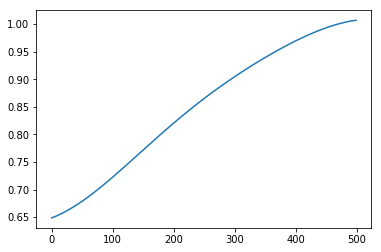

In [8]:
u_enc = o_u.eval(feed_dict={i_x:data})
plt.plot(u_enc)

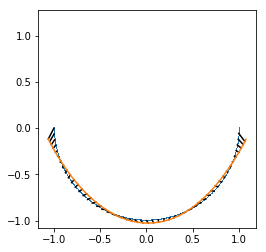

In [9]:
xy_dec = o_xd.eval(feed_dict={i_u:u_enc.reshape(-1,1)})
plt.plot(data[:,0],data[:,1],',')
for a,b in zip(xy_dec,data)[::10]:
    plt.plot( [a[0],b[0]], [a[1],b[1]],'-k')
xy_dec = o_xd.eval(feed_dict={i_u:np.linspace(u_enc.min(),u_enc.max(),100).reshape(-1,1)})
plt.plot(xy_dec[:,0],xy_dec[:,1],'-')
plt.axis('square');

What's the problem? The topology of the constraint manifold is not a plane! When we do the nonlinear mapping to the latent space, we are still in a domain of $-\infty$ to $\infty$. With our prior knowledge, we know the latent space has a loop to it. 

The topological insight (prior knowledge) is that the circular constraint manifold requires two charts [https://en.wikipedia.org/wiki/Atlas_(topology)](https://en.wikipedia.org/wiki/Atlas_(topology)). This translates to having two latent spaces (one for each chart) and then combining them in the decoding phase. There would need to be some other classifier for telling us which chart we are on, which go through a transition map as the coordinates on the two charts are decoded.

We're not interested in problems with nonplanar constraints, for now.